In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator, Pauli, SparsePauliOp, Statevector
from qiskit.circuit import Parameter, ParameterVector
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 as FakeManila
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

# For IBM Quantum access (optional)
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as RuntimeEstimator
    IBM_AVAILABLE = True
except ImportError:
    IBM_AVAILABLE = False
    print("IBM Runtime not available. Install with: pip install qiskit-ibm-runtime")

print("Qiskit imports successful!")
print(f"IBM Quantum Runtime available: {IBM_AVAILABLE}")

Qiskit imports successful!
IBM Quantum Runtime available: True


In [2]:
def create_hamiltonian(h_I, h_X, h_Y, h_Z):
    pauli_list = [('I', h_I), ('X', h_X), ('Y', h_Y), ('Z', h_Z)]
    pauli_list = [(p,c) for p, c in pauli_list if abs(c) > 1e-10]
    if not pauli_list:
        pauli_list = [('I', 0.0)]

    hamiltonian = SparsePauliOp.from_list(pauli_list)
    return hamiltonian

h_I = 1.0
h_X = 0.5
h_Y = 0.3
h_Z = 0.8

hamiltonian = create_hamiltonian(h_I, h_X, h_Y, h_Z)

print("hamiltonian")
print(f"\n H = {h_I:.3f} I + {h_X:.3f} X + {h_Y:.3f} Y + {h_Z:.3f} Z")
print(f"\nqiskit representation:")
print(hamiltonian)

H_matrix = hamiltonian.to_matrix()
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
E_exact = eigenvalues[0]
psi_exact = eigenvectors[:,0]

print(f"\nexact ground state energy : {E_exact:.10f}")
print(f"exact excited state energy : {eigenvalues[1]:.10f}")
print(f"energy gap : {eigenvalues[1] - E_exact:.10f}")

hamiltonian

 H = 1.000 I + 0.500 X + 0.300 Y + 0.800 Z

qiskit representation:
SparsePauliOp(['I', 'X', 'Y', 'Z'],
              coeffs=[1. +0.j, 0.5+0.j, 0.3+0.j, 0.8+0.j])

exact ground state energy : 0.0100505063
exact excited state energy : 1.9899494937
energy gap : 1.9798989873


vqe ansatz circuit:
   ┌──────────┐┌──────────┐┌──────────┐
q: ┤ Rz(θ[0]) ├┤ Ry(θ[1]) ├┤ Rz(θ[2]) ├
   └──────────┘└──────────┘└──────────┘

parameters: θ, ['θ[0]', 'θ[1]', 'θ[2]']


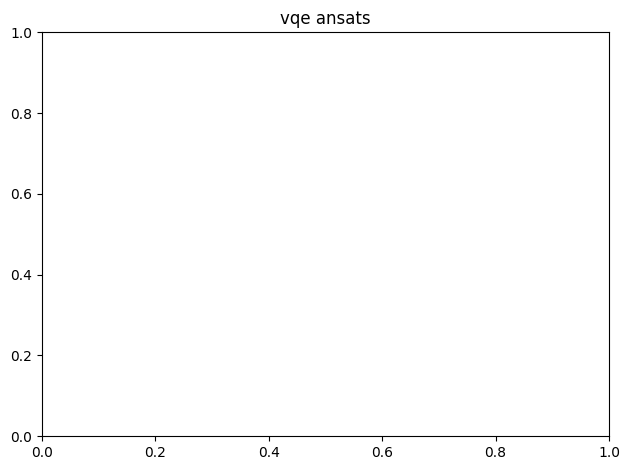

In [3]:
def create_ansatz():
    theta = ParameterVector('θ', 3)
    qc = QuantumCircuit(1)
    qc.rz(theta[0],0)
    qc.ry(theta[1],0)
    qc.rz(theta[2],0)
    return qc, theta

ansatz, params = create_ansatz()

print("vqe ansatz circuit:")
print(ansatz)
print(f"\nparameters: {params}")

ansatz.draw('mpl', style='iqp')
plt.title("vqe ansats")
plt.tight_layout()
plt.show()

In [4]:
class QiskitVQE:

    def __init__(self, hamiltonian, ansatz, estimator, initial_point=None):

        self.hamiltonian = hamiltonian
        self.ansatz = ansatz 
        self.estimator = estimator 
        self.initial_point = initial_point

        self.energy_history = []
        self.param_history = []
        self.n_evaluations = 0

    def cost_function(self, params):

        pub = (self.ansatz, self.hamiltonian, params)
        job = self.estimator.run([pub])
        result = job.result()
        energy = float(result[0].data.evs)

        self.energy_history.append(energy)
        self.param_history.append(params.copy())
        self.n_evaluations += 1

        return energy

    def optimize(self, method="COBYLA", maxiter=100):
        
        if self.initial_point is None:
            self.initial_point = np.random.uniform(0, 2*np.pi, self.ansatz.num_parameters)
        
        print(f"starting vqe optimization")
        print(f"backend: {type(self.estimator).__name__}")
        print(f"method: {method}")
        print(f"initial point: {self.initial_point}")

        self.energy_history = []
        self.param_history = []
        self.n_evaluations = 0

        result = minimize(
            self.cost_function,
            self.initial_point,
            method=method,
            options={'maxiter':maxiter}
        )

        print(f"\noptimization complete")
        print(f"evaluations: {self.n_evaluations}")
        print(f"final energy: {result.fun:.10f}")
        print(f"optimal params: {result.x}")

        return result

print("qiskitvqe class defined")

qiskitvqe class defined


In [5]:
print("vqe on ideal simulator (no noise)")

estimator_ideal = StatevectorEstimator()
vqe_ideal = QiskitVQE(hamiltonian, ansatz, estimator_ideal)
result_ideal = vqe_ideal.optimize(method='COBYLA', maxiter=100)
E_vqe_ideal = result_ideal.fun
params_optimal = result_ideal.x

print(f"exact ground energy: {E_exact:.10f}")
print(f"vqe ground energy: {E_vqe_ideal:.10f}")
print(f"absolute error: {abs(E_vqe_ideal-E_exact):.2e}")
print(f"relative error: {abs(E_vqe_ideal-E_exact)/abs(E_exact)*100:.6f}%")



vqe on ideal simulator (no noise)
starting vqe optimization
backend: StatevectorEstimator
method: COBYLA
initial point: [2.87626745 4.3605078  0.56884326]

optimization complete
evaluations: 59
final energy: 0.0100505064
optimal params: [3.04779633 3.77144256 0.54043394]
exact ground energy: 0.0100505063
vqe ground energy: 0.0100505064
absolute error: 8.91e-11
relative error: 0.000001%


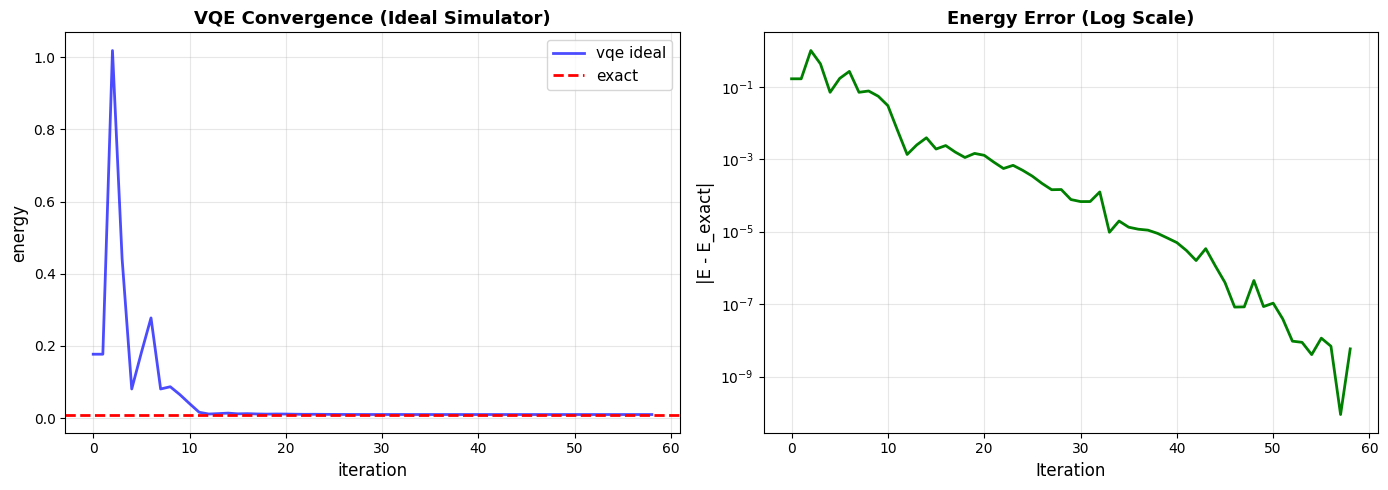

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
ax1 = axes[0]
ax1.plot(vqe_ideal.energy_history, 'b-', linewidth=2, alpha=0.7, label="vqe ideal")
ax1.axhline(y=E_exact, color='r', linestyle='--', linewidth=2, label='exact')
ax1.set_xlabel('iteration', fontsize=12)
ax1.set_ylabel('energy', fontsize=12)
ax1.set_title('VQE Convergence (Ideal Simulator)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
errors = [abs(E - E_exact) for E in vqe_ideal.energy_history]
ax2.semilogy(errors, 'g-', linewidth=2)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('|E - E_exact|', fontsize=12)
ax2.set_title('Energy Error (Log Scale)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

In [7]:
optimal_circuit = ansatz.assign_parameters(params_optimal)
statevector = Statevector.from_instruction(optimal_circuit)
print("vqe final state:")
print(f"|phi> = {statevector.data[0]:.6f} |0> + {statevector.data[1]:.6f} |1>")
fig = plot_bloch_multivector(statevector)
plt.suptitle('vqe ground state on bloch sphere', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

fidelity = abs(np.vdot(psi_exact, statevector.data))**2
print(f"\nfidelity with exact ground state: {fidelity:.10f}")

vqe final state:
|phi> = 0.068598+0.302053j |0> + 0.296491-0.903411j |1>


<Figure size 640x480 with 0 Axes>


fidelity with exact ground state: 1.0000000000


In [8]:
print("vqe on noisy simulator")

# fake_backend = FakeManila()
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)
backend_noisy = AerSimulator(noise_model=noise_model)

print(f"\nnoise model from: {fake_backend}")
print(f"no of qubits: {fake_backend.num_qubits}")
print(f"basis gates: {noise_model.basis_gates}")

from qiskit_aer.primitives import EstimatorV2 as AerEstimator
estimator_noisy = AerEstimator.from_backend(backend_noisy)
vqe_noisy = QiskitVQE(hamiltonian, ansatz, estimator_noisy, initial_point=params_optimal)
result_noisy = vqe_noisy.optimize(method="COBYLA", maxiter=50)

E_vqe_noisy = result_noisy.fun
params_noisy = result_noisy.x

print(f"results (noisy simulator)")
print(f"exact ground energy: {E_exact:.10f}")
print(f"vqe (ideal): {E_vqe_ideal:.10f}")
print(f"vqe (noisy): {E_vqe_noisy:.10f}")
print(f"\nnoise impact: {abs(E_vqe_noisy-E_vqe_ideal):.6f}")
print(f"error (noisy): {abs(E_vqe_noisy-E_exact):.6f}")


vqe on noisy simulator

noise model from: <qiskit_ibm_runtime.fake_provider.backends.manila.fake_manila.FakeManilaV2 object at 0x0000019DBB78C310>
no of qubits: 5
basis gates: ['cx', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
starting vqe optimization
backend: EstimatorV2
method: COBYLA
initial point: [3.04779633 3.77144256 0.54043394]

optimization complete
evaluations: 29
final energy: 0.0100505064
optimal params: [4.04779633 3.77144256 0.54043394]
results (noisy simulator)
exact ground energy: 0.0100505063
vqe (ideal): 0.0100505064
vqe (noisy): 0.0100505064

noise impact: 0.000000
error (noisy): 0.000000


C:\Users\ofurn\AppData\Local\Temp\ipykernel_8136\1416107790.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


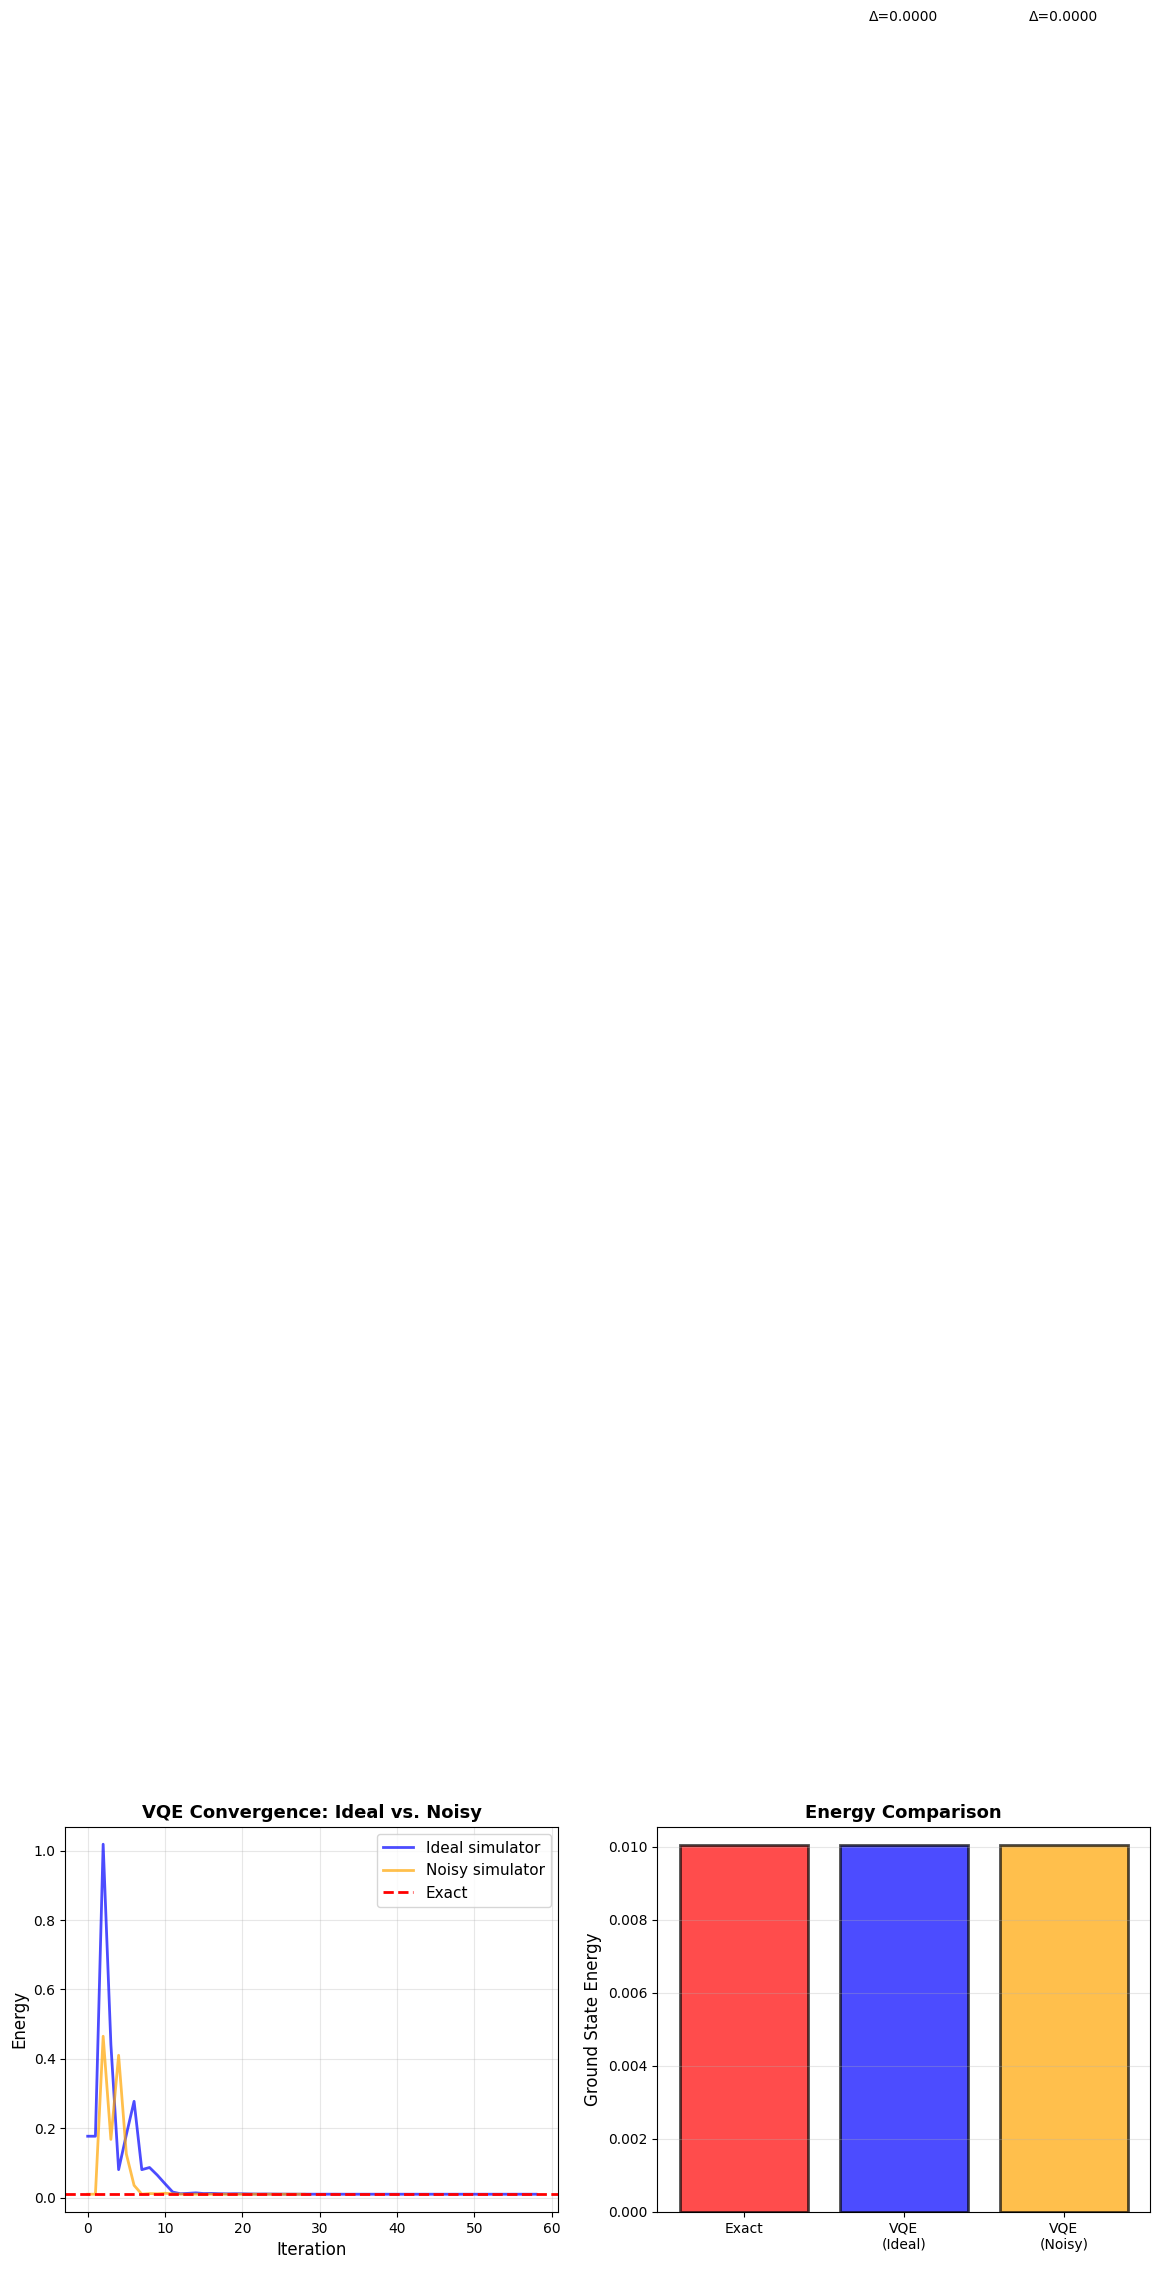

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Convergence comparison
ax1.plot(vqe_ideal.energy_history, 'b-', linewidth=2, label='Ideal simulator', alpha=0.7)
ax1.plot(vqe_noisy.energy_history, 'orange', linewidth=2, label='Noisy simulator', alpha=0.7)
ax1.axhline(y=E_exact, color='r', linestyle='--', linewidth=2, label='Exact')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('VQE Convergence: Ideal vs. Noisy', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Energy bar comparison
energies = [E_exact, E_vqe_ideal, E_vqe_noisy]
labels = ['Exact', 'VQE\n(Ideal)', 'VQE\n(Noisy)']
colors = ['red', 'blue', 'orange']

ax2.bar(labels, energies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Ground State Energy', fontsize=12)
ax2.set_title('Energy Comparison', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add error annotations
for i, (label, energy) in enumerate(zip(labels[1:], energies[1:]), 1):
    error = abs(energy - E_exact)
    ax2.text(i, energy + 0.05, f'Δ={error:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
def measure_pauli_terms(circuit, estimator):
    """
    Measure individual Pauli expectation values.
    """
    pauli_ops = {
        'I': SparsePauliOp.from_list([('I', 1.0)]),
        'X': SparsePauliOp.from_list([('X', 1.0)]),
        'Y': SparsePauliOp.from_list([('Y', 1.0)]),
        'Z': SparsePauliOp.from_list([('Z', 1.0)])
    }
    
    results = {}
    
    for name, op in pauli_ops.items():
        pub = (circuit, op)
        job = estimator.run([pub])
        result = job.result()
        results[name] = float(result[0].data.evs)
    
    return results

# Measure on ideal simulator
circuit_optimal = ansatz.assign_parameters(params_optimal)
measurements_ideal = measure_pauli_terms(circuit_optimal, estimator_ideal)

# Measure on noisy simulator
circuit_noisy = ansatz.assign_parameters(params_noisy)
measurements_noisy = measure_pauli_terms(circuit_noisy, estimator_noisy)

# Display results
print("Pauli Expectation Values:\n")
print(f"{'Pauli':>5s} | {'Coefficient':>12s} | {'Ideal':>12s} | {'Noisy':>12s} | {'Contrib (Ideal)':>16s} | {'Contrib (Noisy)':>16s}")
print("-" * 90)

coeffs = {'I': h_I, 'X': h_X, 'Y': h_Y, 'Z': h_Z}
total_ideal = 0
total_noisy = 0

for pauli in ['I', 'X', 'Y', 'Z']:
    coeff = coeffs[pauli]
    exp_ideal = measurements_ideal[pauli]
    exp_noisy = measurements_noisy[pauli]
    contrib_ideal = coeff * exp_ideal
    contrib_noisy = coeff * exp_noisy
    total_ideal += contrib_ideal
    total_noisy += contrib_noisy
    
    print(f"{pauli:>5s} | {coeff:+12.6f} | {exp_ideal:+12.6f} | {exp_noisy:+12.6f} | {contrib_ideal:+16.6f} | {contrib_noisy:+16.6f}")

print("-" * 90)
print(f"{'Total':>5s} | {'':>12s} | {'':>12s} | {'':>12s} | {total_ideal:+16.6f} | {total_noisy:+16.6f}")
print(f"\nExact: {E_exact:+16.6f}")

Pauli Expectation Values:

Pauli |  Coefficient |        Ideal |        Noisy |  Contrib (Ideal) |  Contrib (Noisy)
------------------------------------------------------------------------------------------
    I |    +1.000000 |    +1.000000 |    +1.000000 |        +1.000000 |        +1.000000
    X |    +0.500000 |    -0.505079 |    -0.505079 |        -0.252540 |        -0.252540
    Y |    +0.300000 |    -0.303057 |    -0.303057 |        -0.090917 |        -0.090917
    Z |    +0.800000 |    -0.808116 |    -0.808116 |        -0.646493 |        -0.646493
------------------------------------------------------------------------------------------
Total |              |              |              |        +0.010051 |        +0.010051

Exact:        +0.010051


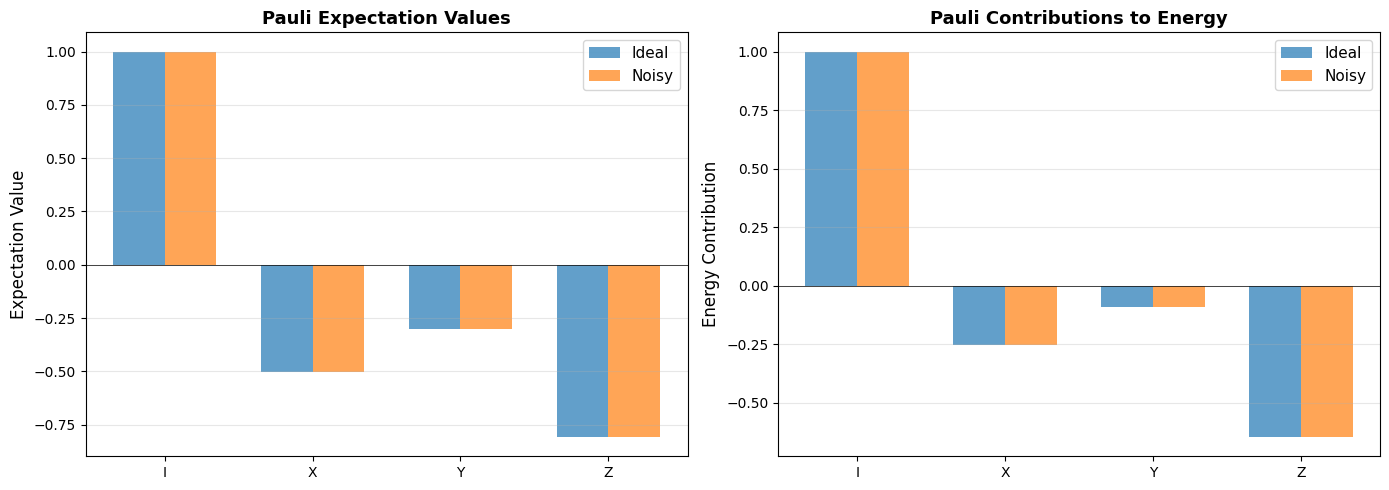

In [11]:
# Visualize Pauli measurements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Expectation values
pauli_names = ['I', 'X', 'Y', 'Z']
ideal_vals = [measurements_ideal[p] for p in pauli_names]
noisy_vals = [measurements_noisy[p] for p in pauli_names]

x = np.arange(len(pauli_names))
width = 0.35

ax1.bar(x - width/2, ideal_vals, width, label='Ideal', alpha=0.7)
ax1.bar(x + width/2, noisy_vals, width, label='Noisy', alpha=0.7)
ax1.set_ylabel('Expectation Value', fontsize=12)
ax1.set_title('Pauli Expectation Values', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(pauli_names)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Energy contributions
ideal_contribs = [coeffs[p] * measurements_ideal[p] for p in pauli_names]
noisy_contribs = [coeffs[p] * measurements_noisy[p] for p in pauli_names]

ax2.bar(x - width/2, ideal_contribs, width, label='Ideal', alpha=0.7)
ax2.bar(x + width/2, noisy_contribs, width, label='Noisy', alpha=0.7)
ax2.set_ylabel('Energy Contribution', fontsize=12)
ax2.set_title('Pauli Contributions to Energy', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(pauli_names)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

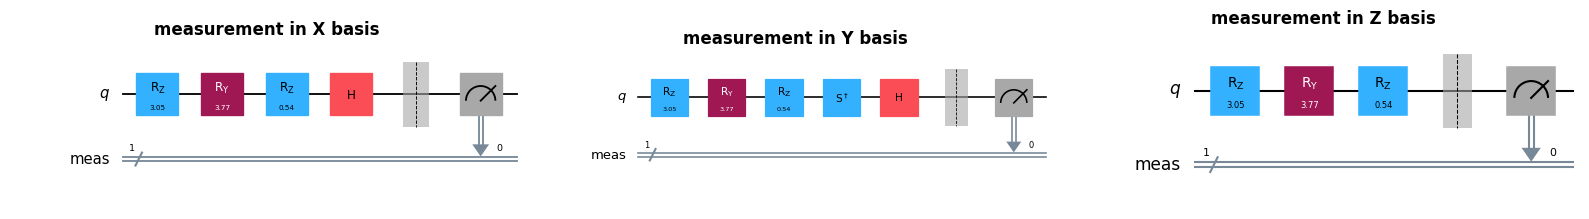

measurement procedure:
X basis: apply H gate before measurement
Y basis: apply S^T H gates before measurement
Z basis: direct measurement (computational basis)


In [12]:
def create_measurement_circuit(ansatz, params, basis='Z'):
    qc = ansatz.assign_parameters(params)
    if basis == 'X':
        qc.h(0)
    elif basis == 'Y':
        qc.sdg(0)
        qc.h(0)
    qc.measure_all()
    return qc

fig, axes = plt.subplots(1,3,figsize=(16,4))
for i, basis in enumerate(['X','Y','Z']):
    meas_circuit = create_measurement_circuit(ansatz, params_optimal, basis)
    meas_circuit.draw('mpl', ax=axes[i], style='iqp')
    axes[i].set_title(f"measurement in {basis} basis", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print('measurement procedure:')
print('X basis: apply H gate before measurement')
print('Y basis: apply S^T H gates before measurement')
print('Z basis: direct measurement (computational basis)')



In [13]:
from qiskit.primitives import BackendEstimatorV2

def run_vqe_with_shots(shots_list):
    results = []

    for shots in shots_list:
        print(f"\nrunning with {shots} shots...")
        backend = AerSimulator()
        estimator = AerEstimator.from_backend(backend)
        estimator.options.default_shots = shots
        vqe = QiskitVQE(hamiltonian, ansatz, estimator, initial_point=params_optimal)
        result = vqe.optimize(method="COBYLA", maxiter=30)

        results.append({
            'shots' : shots,
            'energy' : result.fun,
            'error' : abs(result.fun-E_exact),
            'history' : vqe.energy_history
        })

        print(f"final energy: {result.fun:.6f}, error: {abs(result.fun - E_exact):.6f}")

    return results

shots_list = [100, 500, 1000, 5000, 10000]
shot_results = run_vqe_with_shots(shots_list)


print("shot budget analysis")
print(f"{'Shots':>8s} | {'Energy':>14s} | {'Error':>12s}")
for res in shot_results:
    print(f"{res['shots']:8d} | {res['energy']:+14.10f} | {res['error']:12.6f}")
print(f"{'Exact':>8s} | {E_exact:+14.10f} | {0.0:12.6f}")





running with 100 shots...
starting vqe optimization
backend: EstimatorV2
method: COBYLA
initial point: [3.04779633 3.77144256 0.54043394]

optimization complete
evaluations: 29
final energy: 0.0100505064
optimal params: [3.04779633 3.77144256 0.54043394]
final energy: 0.010051, error: 0.000000

running with 500 shots...
starting vqe optimization
backend: EstimatorV2
method: COBYLA
initial point: [3.04779633 3.77144256 0.54043394]

optimization complete
evaluations: 29
final energy: 0.0100505064
optimal params: [3.04779633 3.77144256 0.54043394]
final energy: 0.010051, error: 0.000000

running with 1000 shots...
starting vqe optimization
backend: EstimatorV2
method: COBYLA
initial point: [3.04779633 3.77144256 0.54043394]

optimization complete
evaluations: 29
final energy: 0.0100505064
optimal params: [3.04779633 3.77144256 0.54043394]
final energy: 0.010051, error: 0.000000

running with 5000 shots...
starting vqe optimization
backend: EstimatorV2
method: COBYLA
initial point: [3.047

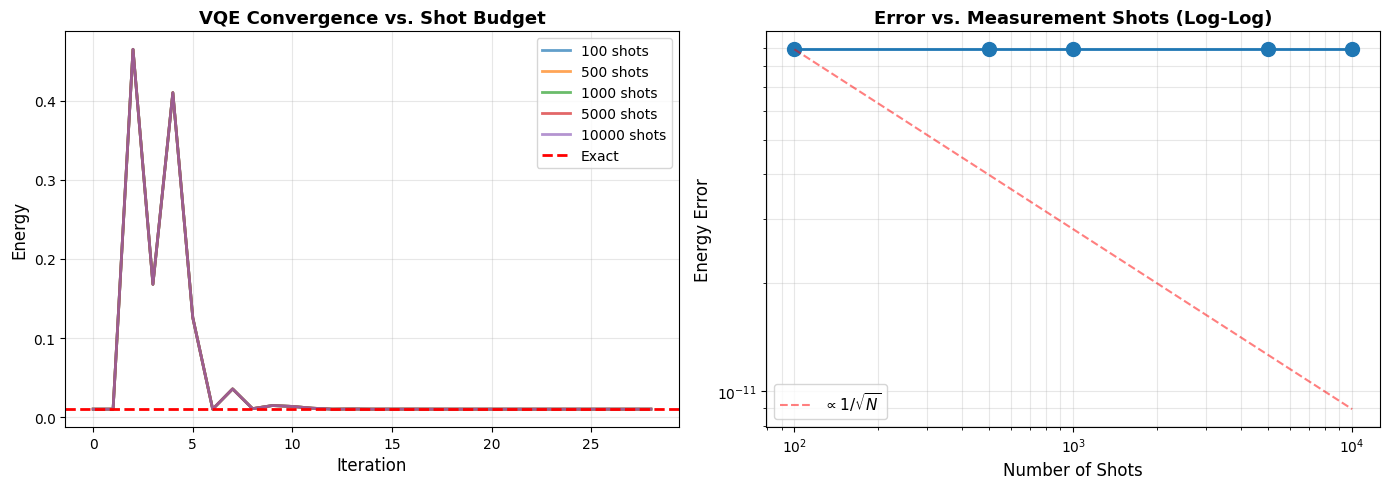


Observation: Error decreases as ~ 1/√N (shot noise)


In [14]:
# Visualize shot dependence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Convergence for different shots
for res in shot_results:
    ax1.plot(res['history'], alpha=0.7, linewidth=2, label=f"{res['shots']} shots")
ax1.axhline(y=E_exact, color='red', linestyle='--', linewidth=2, label='Exact')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('VQE Convergence vs. Shot Budget', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Error vs. shots
shots_vals = [res['shots'] for res in shot_results]
error_vals = [res['error'] for res in shot_results]

ax2.loglog(shots_vals, error_vals, 'o-', linewidth=2, markersize=10)
ax2.set_xlabel('Number of Shots', fontsize=12)
ax2.set_ylabel('Energy Error', fontsize=12)
ax2.set_title('Error vs. Measurement Shots (Log-Log)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

# Add 1/sqrt(N) reference line
shots_ref = np.array(shots_vals)
error_ref = error_vals[0] * np.sqrt(shots_vals[0] / shots_ref)
ax2.plot(shots_ref, error_ref, 'r--', linewidth=1.5, alpha=0.5, label=r'$\propto 1/\sqrt{N}$')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\nObservation: Error decreases as ~ 1/√N (shot noise)")

In [15]:
# Summary table
print("\n" + "="*80)
print("VQE RESULTS SUMMARY")
print("="*80)
print(f"\n{'Method':>30s} | {'Energy':>16s} | {'Error':>14s} | {'Rel. Error (%)':>16s}")
print("-"*80)

methods = [
    ("Exact Diagonalization", E_exact, 0.0),
    ("VQE (Ideal Simulator)", E_vqe_ideal, abs(E_vqe_ideal - E_exact)),
    ("VQE (Noisy Simulator)", E_vqe_noisy, abs(E_vqe_noisy - E_exact)),
]

for method, energy, error in methods:
    rel_error = (error / abs(E_exact) * 100) if E_exact != 0 else 0
    print(f"{method:>30s} | {energy:+16.10f} | {error:14.6e} | {rel_error:16.8f}")

print("\n" + "="*80)
print("KEY OBSERVATIONS")
print("="*80)
print("1. Ideal simulator achieves near-exact results (limited by optimizer)")
print("2. Noisy simulator shows realistic quantum hardware effects")
print("3. Increasing measurement shots reduces statistical error")
print("4. Real hardware would show additional systematic errors")
print("="*80)


VQE RESULTS SUMMARY

                        Method |           Energy |          Error |   Rel. Error (%)
--------------------------------------------------------------------------------
         Exact Diagonalization |    +0.0100505063 |   0.000000e+00 |       0.00000000
         VQE (Ideal Simulator) |    +0.0100505064 |   8.910823e-11 |       0.00000089
         VQE (Noisy Simulator) |    +0.0100505064 |   8.910826e-11 |       0.00000089

KEY OBSERVATIONS
1. Ideal simulator achieves near-exact results (limited by optimizer)
2. Noisy simulator shows realistic quantum hardware effects
3. Increasing measurement shots reduces statistical error
4. Real hardware would show additional systematic errors
